<a href="https://colab.research.google.com/github/z-arabi/pytorch-transformer/blob/main/Vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers from scratch

- [ViT Blogpost by Francesco Zuppichini](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)
- [D2L Tutorial ](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [Brian Pulfer Medium Blogpost](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)
- [Lucidrains implementation Github ](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

## Setup

In [1]:
!pip install einops

## Image Patching



Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


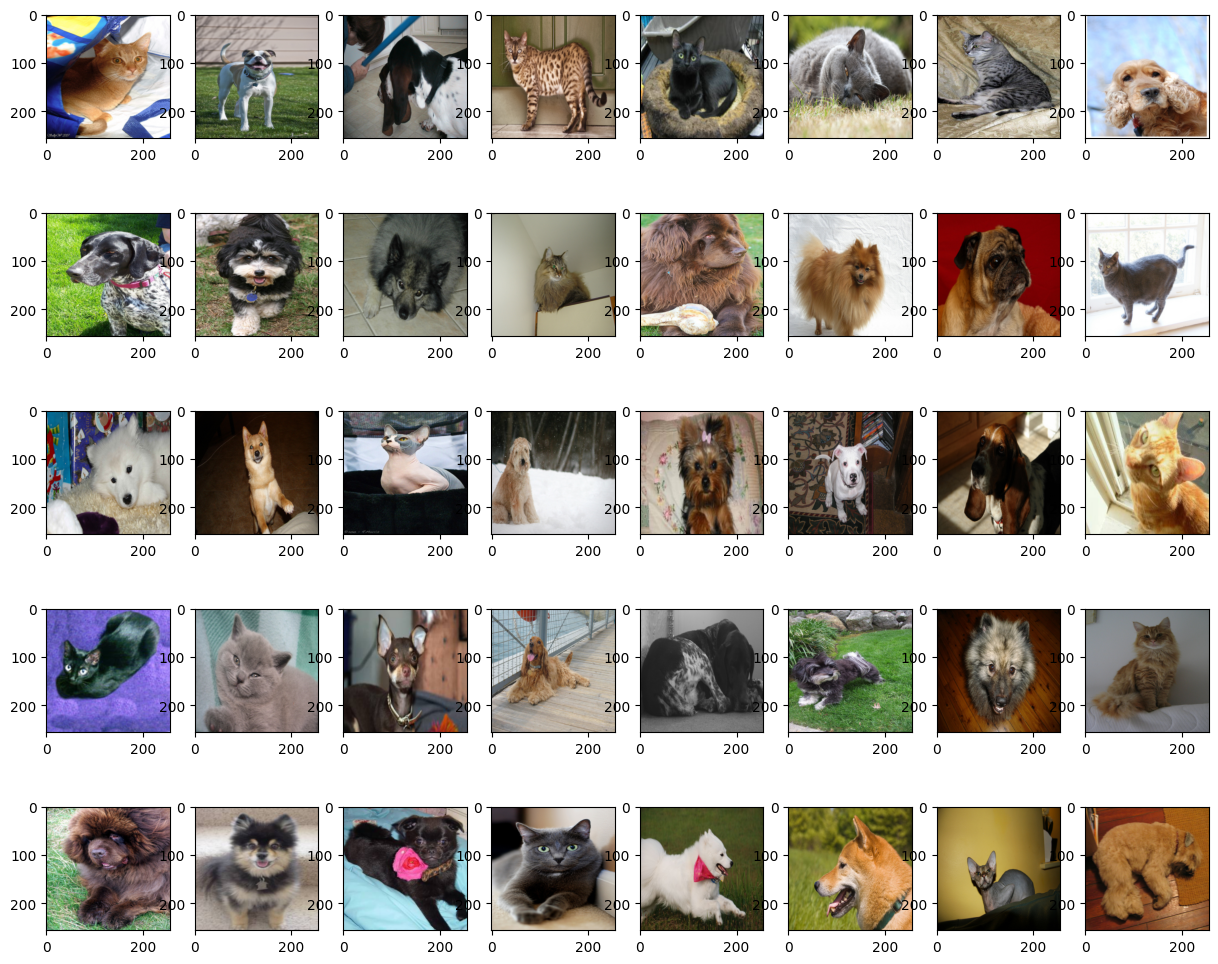

In [2]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((256, 256)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# 200 images for each pet
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

### Patch Images

- The following is mainly from the above implementations (not my code)

torch.Size([3, 256, 256])


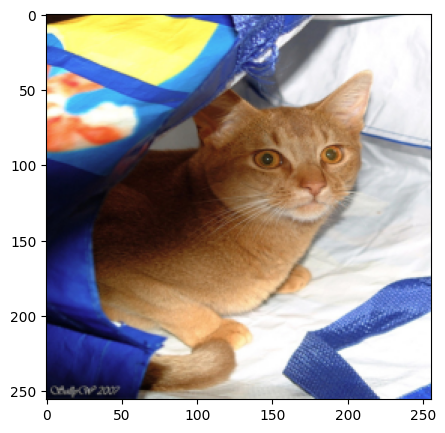

In [3]:
sample = dataset[0][0]
print(sample.shape)
# set the figure size
plt.figure(figsize=(5,5))
plt.imshow(sample.permute(1, 2, 0))

In [4]:
# it uses the FCN for the embedding
# If we want to use the CNN that would be different
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 32, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(sample, 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 256, 256])
Patches shape:  torch.Size([1, 64, 128])


torch.Size([64, 32, 32, 3])


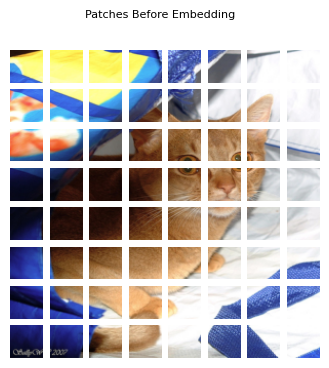

Patches shape:  torch.Size([1, 64, 128])


In [5]:
from einops import rearrange

def visualize_patches(sample_datapoint, patch_size):
    # Rearrange the image into patches
    patches = rearrange(sample_datapoint, 'c (h p1) (w p2) -> (h w) p1 p2 c', p1=patch_size, p2=patch_size)
    print(patches.shape)

    # Plot the patches
    fig, axs = plt.subplots(int(sample_datapoint.shape[1] // patch_size), int(sample_datapoint.shape[2] // patch_size), figsize=(4,4))
    fig.suptitle("Patches Before Embedding", fontsize=8)

    for i, ax in enumerate(axs.flat):
        patch = patches[i]
        ax.imshow(patch.numpy())  # Convert from (C, H, W) to (H, W, C) and to numpy
        ax.axis('off')

    plt.show()

visualize_patches(sample, patch_size=32)

embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

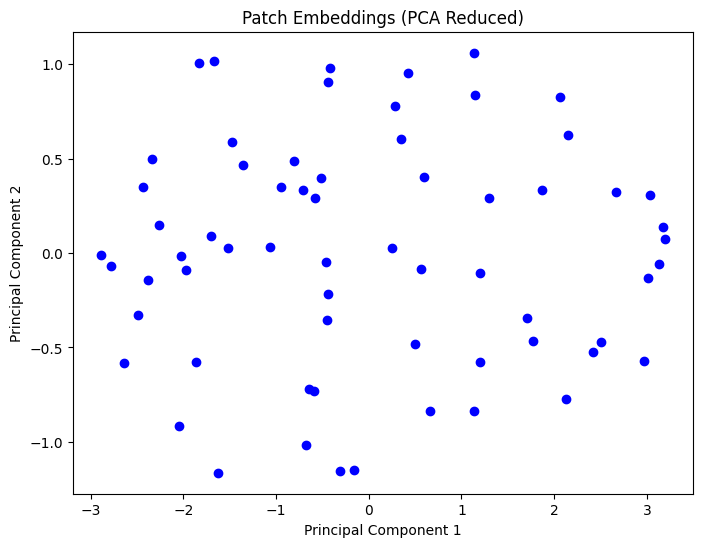

In [6]:
from sklearn.decomposition import PCA
import numpy as np

def visualize_patch_embeddings(embedding):
    # Flatten the embeddings to a 2D array (num_patches, emb_size)
    patches_embeddings = embedding.squeeze(0).detach().cpu().numpy()

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(patches_embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')
    plt.title("Patch Embeddings (PCA Reduced)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Visualize the patch embeddings
# embedding is considering a vector of embed size for each patch (p1,p2,c)
visualize_patch_embeddings(embedding)


## Model

Let's first implement all of the transformer building blocks. These blocks are inspired by the implementations linked above. I've left out some dropouts and normalizations at some places.

In [7]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        # no need to code MHA
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout,
                                               batch_first=True)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model) / bs, num_patches, embed_dim
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        # with batch_first=True > bs, num_patches, embed_dim
        # weights > bs, num_patches, num_patches
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [8]:
Attention(dim=128, n_heads=4, dropout=0.1)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [9]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
      # x has the input of bs, num_patches, embed_dim > layer norm on the dim > bs, num_patches, 1
        return self.fn(self.norm(x), **kwargs)

In [10]:
# First do the normalization, then the attention
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [11]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [12]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [13]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

- Not all parameters are like in the original implementation
- Some Dropouts & Norms are missing

In [14]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        # number of patches: h, w >> The image size: hp, wp
        # output: b, hw, hiddenDim
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        # positional embedding
        # don't need the sin, cos >> only the seq of number of patches >> so it should be 1, num_patches  + 1 (cls), emb_dim
        # for all the baches it has the same and learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        # print(x.shape) # torch.Size([1, 1296, 32]) emded_im=32, (144/4)^2=1296
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[-0.6516, -0.6199, -0.0841, -0.4491, -0.1968, -0.4138,  0.4039, -0.7691,
          0.0830,  0.0942,  0.3221,  1.2916,  0.3873, -0.0559, -0.2213,  0.1133,
          0.7254,  0.7368, -0.4893, -0.4845, -0.2133, -0.3883,  0.4354,  0.3274,
          0.0896, -0.2960, -0.0252, -0.3850, -0.3385,  0.1942, -0.4566,  0.6526,
          1.2105, -0.2465,  0.3260,  0.7770,  0.1671]],
       grad_fn=<AddmmBackward0>)

In [15]:
from torchsummary import summary
# total number of params = 35,301
summary(model, (3, 144, 144))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 1296, 48]               0
            Linear-2             [-1, 1296, 32]           1,568
    PatchEmbedding-3             [-1, 1296, 32]               0
         LayerNorm-4             [-1, 1297, 32]              64
            Linear-5             [-1, 1297, 32]           1,056
            Linear-6             [-1, 1297, 32]           1,056
            Linear-7             [-1, 1297, 32]           1,056
MultiheadAttention-8  [[-1, 1297, 32], [-1, 1297, 1297]]               0
         Attention-9             [-1, 1297, 32]               0
          PreNorm-10             [-1, 1297, 32]               0
      ResidualAdd-11             [-1, 1297, 32]               0
        LayerNorm-12             [-1, 1297, 32]              64
           Linear-13             [-1, 1297, 32]           1,056
             GELU-14          

## Training

In [19]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT(img_size=256, ch=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        print(inputs.shape) #[32, 3, 256, 256]
        print(labels.shape) #[32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

torch.Size([32, 3, 256, 256])
torch.Size([32])


In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([26, 33, 15, 33, 19, 15, 19, 19], device='cuda:0')
Actual classes tensor([32, 22, 23, 23, 20, 13, 31, 12], device='cuda:0')


This needs to train much longer :)